# Uber Marketplace City X Challenge

## Goal
Choose one:
<ol>
<li>Investigate whether Drivers are adequately notified about the city's demand in certain geographic areas at certain times. Present a strategy to address the challenge.
</ol>

## Deliverables

<ol>
<li>An educated, data-driven view on the potential issue
<li>A A/B test design to evalue a hypothesis or test a solution
<li>Recommended next steps and other factors to consider
</ol>

## Evaluation criteria

<ul>
<li>data cleaning, aggregation, and analysis
<li>identification of key patterns and trends
<li>strong and relevant experiment design
<li>recommendations including actionable next steps
<li>acknowledgement of other factors or considerations
</ul>

# TODO List

<ul>
<li>Calculate by-hour statistics for each of the four geos to add to city table
<li>Look at requests vs trips vs. hour by geo
<li>Look into the gap between requests and trips by trip status: rider_canceled vs. unfulfilled
<li>Look into why riders canceled: did they eventually successfully book a trip right after canceling, or is there a correlation between wait time and cancelation rate?
<li>Group trips by driver_id and estimate the trip time by time between pickup and next request time, for times when demand is high (completed trips < trips requested)
</ul>

## Odd Stuff

<ul>
<li>Trip ID 94a1-82d8 is not unique: there four trips with this trip_id. Since four trips will not affect our conclusions these rows are simply dropped 
<li>There is a rider with $139k in payments and over 16k trips. Who could afford to do that (and have enough time) in a lifetime?
<li>similar situation with the driver info: one driver with many more trips than any other
<li>missing est. time to arrival in some 2501 rider trips (about 10% of the total number of trips)
</ul>

In [1]:
import pandas as pd
import math
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(f"This notebook was prepared with:\n  pandas version 0.23.4. Your version: {pd.__version__}")

This notebook was prepared with:
  pandas version 0.23.4. Your version: 0.23.4


## City Demand and Driver Positioning

The city GM believes there are disproportionate levels of surge pricing and higher ETAs in CC - sometimes 1-2 minutes higher than the city average - during rush hour. Also notes trip growth has been inconsistent in April and May. Question: could "fixing" driver placement during CC rush hour help improve rider growth?

Some possible indicators of non-optimal driver positioning could include:
<ul>
<li>surge multiplier disparity: key indicator of poor driver positioning. If surge is 1 or low in one geo and very high in another, drivers could be more optimally positioned. 
<li>fraction of rider cancellations: how does cancellation rate depend on wait time? What is the impact of cancelation on rider retention?
<li>high estimated_times_to_arrival: could indicate poor positioning, but also could be caused by traffic congestion, or lack of driver supply. We can get an idea of the effect of traffic congestion by looking at the number of trips completed per supply hour vs. time of day. 
<li>fraction of trip requests unfulfilled: indicates lack of overall supply. Here, again, looking for disparities between regions would be more indicative of poor positioning, but statistics for unfulfilled trips could be limited
</ul>

## Exploring the city info table

In [3]:
city = pd.read_html("city_metrics.html", header=1, index_col='timestamp')[0]

In [4]:
city['datetime'] = pd.to_datetime(city.index)
city.set_index('datetime', drop=True, inplace=True)
city = city.rename(columns={ 'mean_surge_multipler' : 'mean_surge_multiplier' })
city['date'] = city.index.date
city['dow'] = city.index.day_name()
city['woy'] = city.index.weekofyear
city['hour'] = city.index.hour

In [5]:
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday' ]
rush_hours = [ 7, 8, 17, 18 ] 

In [6]:
city.groupby('woy').agg({'requests':['sum', np.sum( lambda x: 1/np.sqrt(x))]})

Exception: Must produce aggregated value

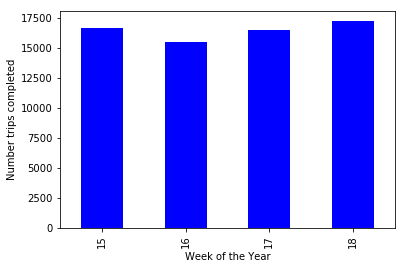

In [7]:
pl = city.groupby('woy').agg('sum').plot(y='trips', kind='bar', color='blue', legend=False)
plt.xlabel("Week of the Year")
plt.ylabel("Number trips completed")

In [8]:
# Trips per supply hour: average number of driver trips/hour 
city['trips_per_supply_hour'] = city['trips']/city['supply_hours']

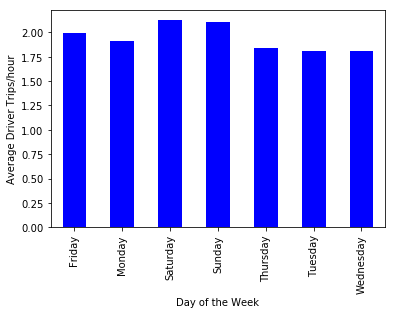

In [9]:
city.groupby('dow').agg('mean').plot(y='trips_per_supply_hour', kind='bar', color='blue', legend=False)
plt.ylabel('Average Driver Trips/hour')
plt.xlabel('Day of the Week')

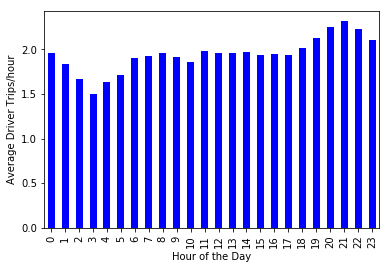

In [10]:
city.groupby('hour').agg('mean').plot(y='trips_per_supply_hour', kind='bar', color='blue', legend=False)
plt.ylabel('Average Driver Trips/hour')
plt.xlabel('Hour of the Day')

In [11]:
# Trip Supply Deficit: Difference between trips completed and requests
city['rider_cancelations_frac'] = (city['requests'] - city['trips'])/city['requests'] 
city['rider_cancelations'] = city['requests'] - city['trips']

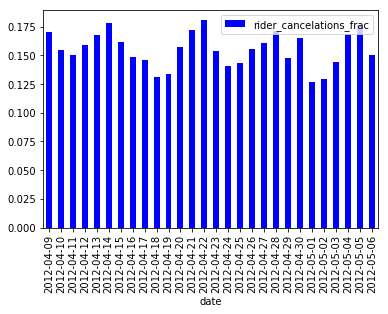

In [12]:
city.groupby('date').agg('mean').plot(y='rider_cancelations_frac', kind='bar', color='blue')

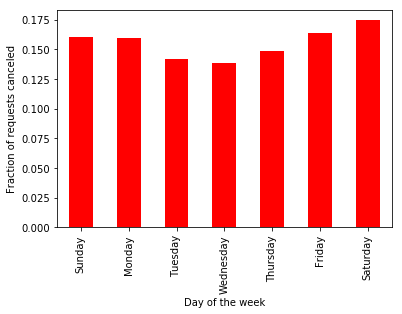

In [13]:
trip_deficit_frac_by_day = city.groupby('dow').agg('mean').loc[['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], :].plot(y='rider_cancelations_frac', kind='bar', color='red',  legend=False)
plt.ylabel("Fraction of requests canceled")
plt.xlabel("Day of the week")

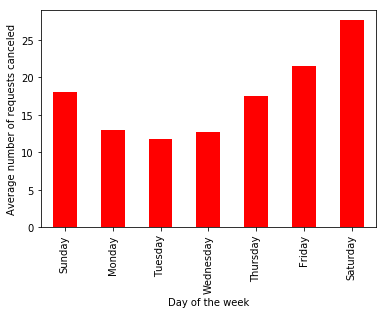

In [14]:
rider_cancelations_number_by_day = city.groupby('dow').agg('mean').loc[['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], :].plot(y='rider_cancelations', kind='bar', color='red',  legend=False)
plt.ylabel("Average number of requests canceled")
plt.xlabel("Day of the week")

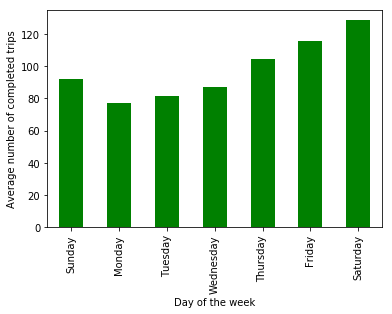

In [15]:
completed_trips_by_day = city.groupby('dow').agg('mean').loc[['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], :].plot(y='trips', kind='bar', color='green',  legend=False)
plt.ylabel("Average number of completed trips")
plt.xlabel("Day of the week")

In [16]:
city_weekdays = city.loc[ city['dow'].isin( weekdays ) ]
weekday_by_hour = city_weekdays.groupby('hour').mean()

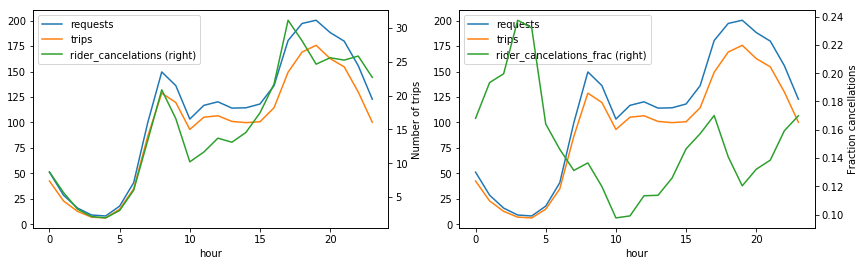

In [240]:
f = plt.figure(figsize=(14,4))
f1 = plt.subplot(121)
weekday_by_hour.plot(y=['requests', 'trips', 'rider_cancelations'], secondary_y=['rider_cancelations'], ax=f1)
plt.ylabel("Number of trips")
f2 = plt.subplot(122)
weekday_by_hour.plot(y=['requests', 'trips', 'rider_cancelations_frac'], secondary_y=['rider_cancelations_frac'], ax=f2)
l = plt.ylabel('Fraction cancellations')


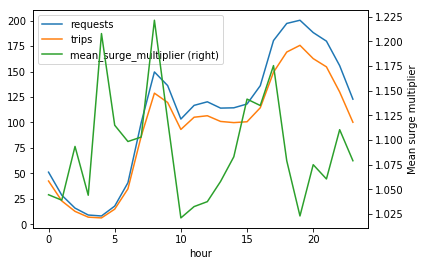

In [242]:
weekday_by_hour.plot(y=['requests', 'trips', 'mean_surge_multiplier'], secondary_y=['mean_surge_multiplier'])
l = plt.ylabel("Mean surge multiplier")
l2 = plt.xlabel("Weekday hour of day")

The definition of "rush hour" is somewhat subjective, but we will assume that it includes mornings 8-9 and evenings: 17-20

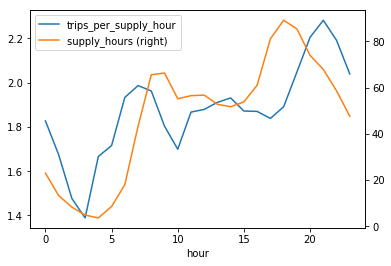

In [20]:
weekday_by_hour.plot(y=['trips_per_supply_hour', 'supply_hours'], secondary_y=['supply_hours'])

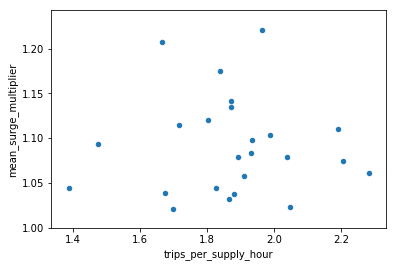

In [21]:
weekday_by_hour.plot( y='mean_surge_multiplier', x='trips_per_supply_hour', kind='scatter')

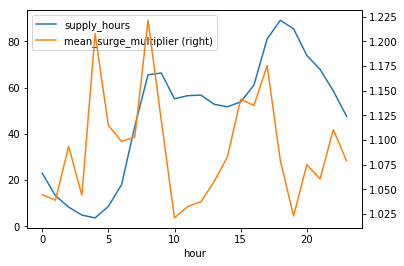

In [22]:
weekday_by_hour.plot(y=['supply_hours', 'mean_surge_multiplier'], secondary_y=['mean_surge_multiplier'])

## Trips Data import, cleaning, and aggregation

In [23]:
d_trips = pd.read_html("driver_trips.html", header=1, index_col='trip_id')[0] 

In [24]:
r_trips = pd.read_html("rider_trips.html", header=1, index_col='trip_id')[0]

In [25]:
drivers = pd.read_html("driver_data.html", header=1, index_col='driver_id')[0]
riders = pd.read_html("rider_data.html", header=1, index_col='rider_id')[0]

In [26]:
d_trips.drop(columns="1", inplace=True)
r_trips.drop(columns="1", inplace=True)
drivers.drop(columns="1", inplace=True)
riders.drop(columns="1", inplace=True)

In [27]:
# Join the driver trips and rider trips tables on trip_id
trips = r_trips.join(d_trips, how='left', lsuffix='_d', rsuffix='_r')

In [28]:
dup_columns = [ c_name.replace("_r", "") for c_name in trips.columns if "_r" in c_name ]
for c in dup_columns:
    r_col = c + "_r"
    d_col = c + "_d"
    trips[c] = trips[r_col].where( ~trips[r_col].isnull(), trips[d_col] )
    trips = trips.drop(columns=[r_col, d_col])

In [29]:
# This trip_id is not unique!
trips = trips.drop('94a1-82d8', axis=0)

In [70]:
trips.index.values

array(['8000-41de', '8000-50ca', '8000-6095', ..., 'bffe-e7af',
       'bfff-8f92', 'bfff-cd09'], dtype=object)

In [77]:
# We need to take the trip_id out of the index before we groupby, or else we'll lose it.
trips['trip_id'] = trips.index.values

In [31]:
trips['is_rush_hour'] = ( trips.hour.isin(rush_hours)) & ( trips.dow.isin(weekdays) )
trips['completed'] = trips.trip_status.apply(lambda x : 1 if x == 'completed' else 0)
trips['canceled'] = trips.trip_status.apply(lambda x : 1 if x == 'rider_canceled' else 0)

In [81]:
completed_trips = trips.loc[trips['trip_status']=='completed']

In [82]:
completed_trips

,rider_id,estimated_time_to_arrival,trip_price_pre_discount,rider_payment,driver_id,actual_time_to_arrival,driver payout,trip_status,request_time,surge_multiplier,start_geo,end_geo,dow,date,hour,is_rush_hour,completed,canceled,trip_id
trip_id,,,,,,,,,,,,,,,,,,,
8000-50ca,991c-b9bb,3.50,6.104,5.4936,49c5-1b68,2.55,4.88,completed,2012-04-23 12:17:00,1.2,Chelsea Court,Chelsea Court,Monday,2012-04-23,12,False,1,0,8000-50ca
8000-6095,be95-fe1e,6.73,6.696,6.6960,401a-3f3a,5.25,5.36,completed,2012-04-20 09:58:00,1.0,Chelsea Court,Blair Bend,Friday,2012-04-20,9,False,1,0,8000-6095
8000-6624,05f9-5087,0.93,6.368,6.3680,443a-6a1b,0.83,5.09,completed,2012-04-19 08:40:00,1.0,Chelsea Court,Chelsea Court,Thursday,2012-04-19,8,True,1,0,8000-6624
8001-3911,317c-651d,0.70,6.504,6.5040,45a5-92ef,0.27,5.20,completed,2012-05-06 21:51:00,1.3,Chelsea Court,Chelsea Court,Sunday,2012-05-06,21,False,1,0,8001-3911
8001-5a1f,414c-cb3a,0.67,6.280,6.2800,400f-2938,0.02,5.02,completed,2012-05-04 13:15:00,1.0,Chelsea Court,Chelsea Court,Friday,2012-05-04,13,False,1,0,8001-5a1f
8002-8a65,1560-095e,3.65,6.608,5.9472,4109-dcf3,2.82,5.29,completed,2012-04-23 09:12:00,1.3,Chelsea Court,Chelsea Court,Monday,2012-04-23,9,False,1,0,8002-8a65
8003-00a1,d5d9-61f6,5.67,8.928,8.9280,4c4f-a9b8,3.58,7.14,completed,2012-05-05 10:34:00,1.9,Chelsea Court,Chelsea Court,Saturday,2012-05-05,10,False,1,0,8003-00a1
8003-e0b5,60f1-9fea,3.80,7.880,7.8800,452f-d2bd,2.53,6.30,completed,2012-04-11 14:32:00,1.0,Chelsea Court,Chelsea Court,Wednesday,2012-04-11,14,False,1,0,8003-e0b5
8004-72d1,2156-aaf9,3.50,13.824,13.8240,4f0f-e6b8,4.12,11.06,completed,2012-04-29 15:30:00,1.0,Chelsea Court,Chelsea Court,Sunday,2012-04-29,15,False,1,0,8004-72d1


In [83]:
completed_trips.groupby('driver_id').count()

,rider_id,estimated_time_to_arrival,trip_price_pre_discount,rider_payment,actual_time_to_arrival,driver payout,trip_status,request_time,surge_multiplier,start_geo,end_geo,dow,date,hour,is_rush_hour,completed,canceled,trip_id
driver_id,,,,,,,,,,,,,,,,,,
4001-0b52,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4001-316d,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
4001-340c,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
4001-ca7b,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
4001-d6ef,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
4002-35d5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4002-405b,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
4002-6de9,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
4002-706d,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


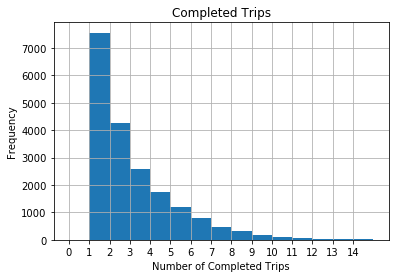

In [84]:
completed_trips.groupby('driver_id').agg({'trip_id':'count'}).sort_values('trip_id', ascending=False).rename(columns={'trip_id':'Completed Trips'}).hist(range=(0, 15), bins=15, )
plt.ylabel('Frequency')
plt.xlabel('Number of Trips Completed by Driver')
ax = plt.xticks(np.arange(0, 15, 1))

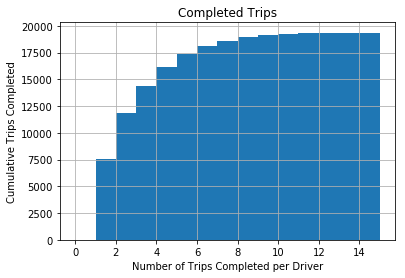

In [85]:
ax = completed_trips.groupby('driver_id').agg({'trip_id':'count'}).sort_values('trip_id', ascending=False).rename(columns={'trip_id':'Completed Trips'}).hist(range=(0, 15), bins=15, cumulative=1)
plt.ylabel("Cumulative Trips Completed")
plt.xlabel("Number of Trips Completed per Driver")

In [138]:
canceled_trips = trips.loc[trips['trip_status']=='rider_canceled']

In [139]:
canceled_trips.groupby('driver_id')['canceled'].count().sort_values(ascending=False).head(10)

driver_id
4e79-a40f    80
4944-de55     7
4e0b-08df     6
4c5a-bdaf     5
4f71-6965     5
432f-c925     5
4b24-2cba     4
4677-5df9     4
4606-155f     4
4706-ed8f     4
Name: canceled, dtype: int64

In [140]:
local_driver_data = completed_trips.groupby('driver_id').agg({'trip_id':'count'}).rename(columns={'trip_id':'completed'}).join(canceled_trips.groupby('driver_id').agg({'trip_id':'count'}).rename(columns={'trip_id':'canceled'}), on='driver_id', how='inner', lsuffix='_comp', rsuffix='_canc')

In [141]:
local_driver_data['fraction_canceled'] = local_driver_data['canceled']/(local_driver_data['canceled']+ local_driver_data['completed'])

In [142]:
local_driver_data.loc[local_driver_data['completed']>20]


,completed,canceled,fraction_canceled
driver_id,,,
4e79-a40f,2210,80,0.034934


In [143]:
drivers.loc[drivers.index == '4e79-a40f']

,first_completed_trip,lifetime_rating,lifetime_fares,lifetime_completed_trips
driver_id,,,,
4e79-a40f,10/12/2010,4.99,8.054105e+08,41940330


In [144]:
n_impossible = drivers.loc[drivers.index == '4e79-a40f']['lifetime_completed_trips'].values[0]
n_years = n_impossible/12/24/365.25
print(f"This driver has a lifetime number of completed trips that, assuming just 5 minutes per trip, would take {round(n_years,0)} years to accomplish, driving non-stop.")

This driver has a lifetime number of completed trips that, assuming just 5 minutes per trip, would take 399.0 years to accomplish, driving non-stop.


In [145]:
len(trips.loc[ (trips.driver_id=='4e79-a40f') & (trips.trip_status=='completed') ])

2210

In [149]:
cancels_per_driver = trips.loc[ (trips.trip_status=='rider_canceled')].groupby('driver_id').agg({'trip_id':'count'}).rename(columns={'trip_id':'canceled'})

In [150]:
completed_per_driver = trips.loc[ (trips.trip_status=='completed')].groupby('driver_id').agg({'trip_id':'count'}).rename(columns={ 'trip_id':'completed' })

In [151]:
requests_per_driver = trips.groupby('driver_id').agg({'trip_id':'count'}).rename(columns={'trip_id':'requests'})

In [152]:
driver_stats = requests_per_driver.join(cancels_per_driver, how='left', on='driver_id')
driver_stats = driver_stats.join(completed_per_driver, how='left', on='driver_id')
driver_stats = driver_stats.fillna(0)
driver_stats['percent_canceled'] = 100*driver_stats['canceled']/driver_stats['requests']
driver_stats = driver_stats.sort_values(['percent_canceled', 'requests'], ascending=[False, True])

In [153]:
driver_stats.completed.describe()

count    20201.000000
mean         2.679966
std         15.677789
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max       2210.000000
Name: completed, dtype: float64

In [154]:
casual_drivers = driver_stats.loc[ (driver_stats['requests']==1) & (driver_stats['canceled']==1) ] 
len(casual_drivers)

775

In [155]:
casual_drivers = casual_drivers.append( driver_stats.loc[ (driver_stats['requests']==2) & (driver_stats['canceled']==1) ] )

In [156]:
casual_drivers = casual_drivers.append(driver_stats.loc[ (driver_stats['requests']==2) & (driver_stats['canceled']==2) ] )
2*len(driver_stats.loc[ (driver_stats['requests']==2) & (driver_stats['canceled']==2) ])

124

In [157]:
len(casual_drivers)

1613

In [158]:
casual_drivers = casual_drivers.join(drivers, how='left')

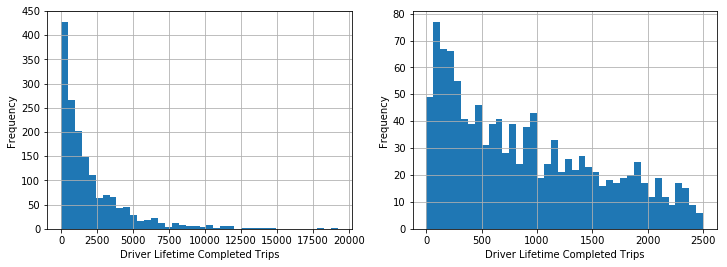

In [178]:
plt.figure(figsize=(12,4))
plt.subplot(121)
casual_drivers['lifetime_completed_trips'].hist(bins=40)
plt.ylabel("Frequency")
plt.xlabel("Driver Lifetime Completed Trips")
plt.subplot(122)
casual_drivers['lifetime_completed_trips'].hist(bins=40, range=(0,2500))
plt.ylabel("Frequency")
plt.xlabel("Driver Lifetime Completed Trips")

## Rider Cancelations

In [179]:
# If a rider orders another trip within 20 minutes and it's completed successfully, let's 
# assume the rider canceled because they either weren't ready or made a mistake. 
# However, if they don't ever request another trip, this is a big deal
rider_request_mistakes = []
rider_cancel_last_trip = []
time_to_rerequest = []

# For those riders who
time_to_next_completed_trip = []
for trip in canceled_trips.itertuples():
    window_start = trip.request_time
    window_end = trip.request_time + dt.timedelta(minutes=20)
    subsequent_requests = trips.loc[   (trips['rider_id']==trip.rider_id) \
                                     & (trips['request_time']>window_start) \
                                     & (trips['request_time']<window_end) \
                                     & (trips['trip_status']=='completed') ]
    if (len(subsequent_requests)>0):
        rider_request_mistakes.append(trip.Index)
        time_to_rerequest.append( subsequent_requests.request_time - trip.request_time )

    later_requests = trips.loc[   (trips['rider_id']==trip.rider_id) \
                                & (trips['request_time']>window_end) \
                                & (trips['trip_status']=='completed') ]
    if len(later_requests)==0:
        rider_cancel_last_trip.append(trip.Index)
    else:
        later_requests.sort_values('request_time')
        time_to_next_completed_trip.append( later_requests.iloc[0]['request_time'] \
                                          - trip.request_time )
        

            

In [181]:
fraction_rider_reorders = len(rider_request_mistakes)/len(canceled_trips)
fraction_rider_reorders

0.007616409901332871

We can see from the calculation above that less than 1% of the time that a rider cancels, s/he reorders and has a successfully completed trip within 20 minutes of the canceled trip. 

In [183]:
fraction_riders_lost = len(rider_cancel_last_trip)/len(canceled_trips)
fraction_riders_lost

0.9008135710576424

The above calculation shows that for 90% of cancelations, the rider __does not__ book another trip within the timeframe of the analysis. We should be concerned that we are at risk of losing these riders.

In [197]:
print(f"Mean time to next request: {np.mean(time_to_next_completed_trip)}")
print(f"Median time to next request: {np.median(time_to_next_completed_trip)}")
print(f"Fraction of riders canceling in this category: {round(100*len(time_to_next_completed_trip)/len(canceled_trips),2)}%")

Mean time to next request: 7 days 19:09:30.157068
Median time to next request: 6 days 03:20:00
Fraction of riders canceling in this category: 9.92%


For the remaining ~10% who do eventually book again, the average time to their next request is about 1 week. 

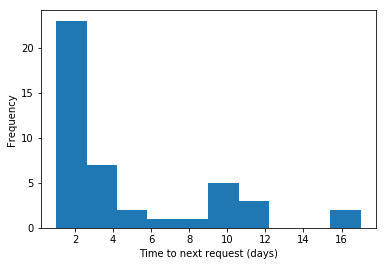

In [192]:
x, y, z = plt.hist( time_to_rerequest/np.timedelta64(60, 's') )
ax = plt.xlabel("Time to next request (days)")
ax = plt.ylabel("Frequency")

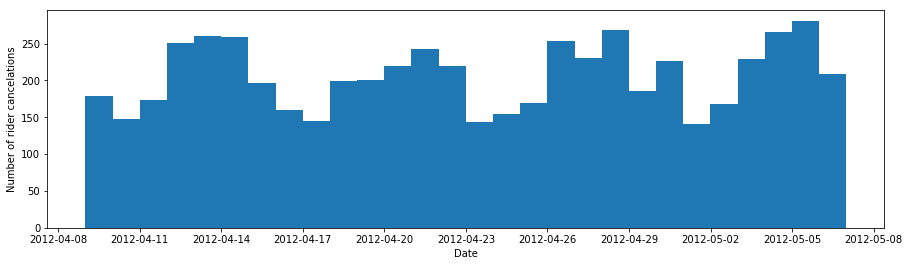

In [219]:
f = plt.figure(figsize=(15,4))
x, y, z = plt.hist(canceled_trips.request_time.values, bins=int((trips.date.max()-trips.date.min())/dt.timedelta(1)+1))
plt.xlabel("Date")
a = plt.ylabel("Number of rider cancelations")


## Statistics of completed and canceled trips

In [220]:
def norm_perc(x, n):
    return (np.round(100*len(x)/n,1), np.round((100*len(x)*np.sqrt(1/n)/n),1))

In [230]:
n_canceled_trips = len(canceled_trips)
canceled_trips.groupby("start_geo").agg({
    'estimated_time_to_arrival':['mean', 'std', 'median'], 
    'surge_multiplier':['mean', 'std', 'median'], 
    'rider_payment':['mean'], 
    'rider_id':['count', lambda x: norm_perc(x, n_canceled_trips)]}).round(2).rename(columns={'<lambda>': '(total trips, uncertainty)%', 'rider_id':'All Canceled Trips'})

estimated_time_to_arrival              surge_multiplier        \
                                   mean   std median             mean   std   
start_geo                                                                     
Allen Abby                         4.63  3.19   4.07             1.21  0.39   
Blair Bend                         5.78  3.80   5.03             1.29  0.45   
Chelsea Court                      4.39  2.90   3.95             1.22  0.39   
Daisy Drive                        4.40  2.99   3.80             1.12  0.29   

                     rider_payment All Canceled Trips  \
              median          mean              count   
start_geo                                               
Allen Abby       1.0          0.73                878   
Blair Bend       1.0          0.74                464   
Chelsea Court    1.0          0.64               4025   
Daisy Drive      1.0          0.77                410   

                                           
              (total trips, uncertainty)%  
start_geo                                  
Allen Abby                    (15.2, 0.2)  
Blair Bend                     (8.0, 0.1)  
Chelsea Court                 (69.7, 0.9)  
Daisy Drive                    (7.1, 0.1)

In [229]:
completed_trips = trips.loc[trips['trip_status']=='completed']
n_completed_trips = len(completed_trips)
completed_trips.groupby('start_geo').agg({
    'estimated_time_to_arrival':['mean', 'std'], 
    'surge_multiplier':['mean', 'std', 'median'], 
    'rider_payment':['mean'], 
    'rider_id':['count', lambda x: norm_perc(x, n_completed_trips)]}).round(2).rename(columns={'<lambda>': '(total trips, uncertainty)%', 'rider_id':'All Completed Trips'})

estimated_time_to_arrival       surge_multiplier               \
                                   mean   std             mean   std median   
start_geo                                                                     
Allen Abby                         3.14  1.99             1.16  0.36    1.0   
Blair Bend                         4.24  2.48             1.20  0.36    1.0   
Chelsea Court                      3.01  1.88             1.15  0.32    1.0   
Daisy Drive                        3.18  1.99             1.10  0.25    1.0   

              rider_payment All Completed Trips                              
                       mean               count (total trips, uncertainty)%  
start_geo                                                                    
Allen Abby             8.50                9600                 (17.7, 0.1)  
Blair Bend             9.88                3899                  (7.2, 0.0)  
Chelsea Court          7.96               36285                 (67.0, 0.3)  
Daisy Drive            9.07                4354                  (8.0, 0.0)

In [223]:
completed_trips_rush = completed_trips.loc[completed_trips['is_rush_hour']==True]
canceled_trips_rush = canceled_trips.loc[canceled_trips['is_rush_hour']==True]
n_completed_trips_rush = len(completed_trips_rush)
n_canceled_trips_rush = len(canceled_trips_rush)

In [228]:
canceled_trips_rush.groupby("start_geo").agg({
    'estimated_time_to_arrival':['mean', 'std', 'median'], 
    'surge_multiplier':['mean', 'std', 'median'], 
    'rider_payment':['mean'], 
    'rider_id':['count', lambda x: norm_perc(x, n_canceled_trips_rush)]}).round(2).rename(columns={'<lambda>': '(total trips, uncertainty)%', 'rider_id':'Canceled Rush-hour Trips'})

estimated_time_to_arrival              surge_multiplier        \
                                   mean   std median             mean   std   
start_geo                                                                     
Allen Abby                         5.60  3.34   5.75             1.32  0.49   
Blair Bend                         5.77  3.80   4.92             1.28  0.41   
Chelsea Court                      5.46  3.25   4.98             1.33  0.50   
Daisy Drive                        5.00  3.35   4.60             1.16  0.29   

                     rider_payment Canceled Rush-hour Trips  \
              median          mean                    count   
start_geo                                                     
Allen Abby       1.0          0.74                      144   
Blair Bend       1.0          0.83                       77   
Chelsea Court    1.0          0.59                      740   
Daisy Drive      1.0          0.77                       64   

                                           
              (total trips, uncertainty)%  
start_geo                                  
Allen Abby                    (14.0, 0.4)  
Blair Bend                     (7.5, 0.2)  
Chelsea Court                 (72.2, 2.3)  
Daisy Drive                    (6.2, 0.2)

In [227]:
completed_trips_rush.groupby('start_geo').agg({
    'estimated_time_to_arrival':['mean', 'std', 'median'], 
    'surge_multiplier':['mean', 'std', 'median'], 
    'rider_payment':['mean'],
    'rider_id':['count', lambda x: norm_perc(x, n_completed_trips_rush)]
}).round(2).rename(columns={'<lambda>': '(total trips, uncertainty)%', 'rider_id':'Completed Rush-hour Trips'})

estimated_time_to_arrival              surge_multiplier        \
                                   mean   std median             mean   std   
start_geo                                                                     
Allen Abby                         3.26  2.15   2.78             1.20  0.49   
Blair Bend                         4.35  2.35   3.98             1.21  0.32   
Chelsea Court                      3.21  1.97   2.85             1.20  0.38   
Daisy Drive                        3.35  2.13   2.93             1.19  0.32   

                     rider_payment Completed Rush-hour Trips  \
              median          mean                     count   
start_geo                                                      
Allen Abby       1.0          8.89                      1665   
Blair Bend       1.0          9.83                       702   
Chelsea Court    1.0          8.05                      5583   
Daisy Drive      1.0          9.63                       773   

                                           
              (total trips, uncertainty)%  
start_geo                                  
Allen Abby                    (19.1, 0.2)  
Blair Bend                     (8.0, 0.1)  
Chelsea Court                 (64.0, 0.7)  
Daisy Drive                    (8.9, 0.1)

In [ ]:
weekday_by_hour.plot(x='requests', y='mean_surge_multiplier', kind='scatter')

In [ ]:
weekday_by_hour.plot( y='mean_surge_multiplier', x='trips_per_supply_hour', kind='scatter')

In [ ]:
weekday_by_hour.plot( y='mean_surge_multiplier', x='supply_hours', kind='scatter')

In [ ]:
trips.trip_status.value_counts()

In [ ]:
trips_by_hour_means = trips.groupby(['date', 'hour']).mean()
trips_by_hour_counts = trips.groupby(['date', 'hour']).count()
trips_by_hour_status = trips.groupby(['date', 'hour', 'trip_status']).count()

In [ ]:
trips_by_hour_counts.sum()

In [ ]:
trips_by_hour = trips.groupby(['hour']).agg({
    'rider_id':'count', 
    'estimated_time_to_arrival':'mean',
    'actual_time_to_arrival':'mean',
    'trip_price_pre_discount':'mean', 
    'completed':'sum', 'canceled':'sum'
})

In [ ]:
trips_by_hour.plot(y='estimated_time_to_arrival')

In [ ]:
weekday_trips_by_hour = trips.loc[trips['dow'].isin(weekdays)].groupby('hour', 'start_geo').mean()['estimated_time_to_arrival'].unstack().plot()

In [ ]:
unfulfilled = trips.loc[ trips['trip_status'] == "unfulfilled" ]

In [ ]:
start_geo_counts = trips['start_geo'].value_counts()/len(trips)
start_geo_counts

In [ ]:
unfulfilled['start_geo'].value_counts()/len(unfulfilled)

In [ ]:
E